<a id='content'></a>
# Welcome to the cooltools pileups notebook!

Averaging of Hi-C/Micro-C maps is a method to get general patterns observed in the maps. It comes in various forms: scaling plots, saddle plots, and pileup plots. **Pileup plot** is the averaged local Hi-C map over the 2D windows (i.e. **snippets**). It also can be found as "average Hi-C" in papers. 

Pileup plot is a powerful technique that solves several problems for Hi-C data analysis: 
- No need to scroll manually through the map in search of general patterns (loops, TADs, or flames),
- The patterns are more visible and reliable if averaged over a number of genomic regions. Especially relevant for low-coverage Hi-C and single-cell Hi-C. 

For pileups, we retrieve local windows that are centered at the **anchors**. We call this procedure **snipping**. Anchors can be ChIP-Seq binding sites, or positions of loops, or any other genomic features. Pileups come in two varieties: 
- **On-diagonal pileup**. Each window is centered at the pixel located at the anchor position, at the main diagonal. Both coordinates of the window center are equivalent to the bin of the anchor. 
- **Off-diagonal pileup**. Each window is centered at the pixel with one anchor as a left coordinate and another anchor as a right coordinate. 
Typically, the sizes of windows are equivalent. After the selection of windows, we average them elementwise. 

### Content

1. [Download data](#data_download)
2. [Load data](#load_data)
    - [Load genomic regions](#load_regions) (chromosome arms or chromosomes)
    - [Load features for anchors](#load_anchors)
3. [On-diagonal pipeup of CTCF](#ondiag)
    - [On-diagonal pileup of ICed Hi-C interactions](#iced)
    - [On-diagonal pileup of observed over expected interactions](#ooe)
    - [Inspect the snips](#snips)
4. [Off-diagonal pileup of CTCF](#offdiag)

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# import libraries for biological data analysis
import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

<a id='data_download'></a>
## 1. Download data

For the test, we collected the data from [immortalized human foreskin fibroblast cell line HFFc6](https://data.4dnucleome.org/ontology-terms/EFO:0009318/):
- Micro-C data from [Krietenstein et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32213324/)
- ChIP-Seq for CTCF from [ENCODE ENCSR000DWQ](https://www.encodeproject.org/experiments/ENCSR000DWQ/)

You can automatically download test datasets with cooltools. More information on the files and how they were obtained is available from the datasets description. 

[Go to top](#content)

In [3]:
# Print available datasets for download
cooltools.print_available_datasets()

1) HFF_MicroC : Micro-C data from HFF human cells for two chromosomes (hg38) in a multi-resolution mcool format. 
	Downloaded from https://osf.io/3h9js/download 
	Stored as test.mcool 
	Original md5sum: e4a0fc25c8dc3d38e9065fd74c565dd1

2) HFF_CTCF_fc : ChIP-Seq fold change over input with CTCF antibodies in HFF cells (hg38). Downloaded from ENCODE ENCSR000DWQ, ENCFF761RHS.bigWig file 
	Downloaded from https://osf.io/w92u3/download 
	Stored as test_CTCF.bigWig 
	Original md5sum: 62429de974b5b4a379578cc85adc65a3

3) HFF_CTCF_binding : Binding sites called from CTCF ChIP-Seq peaks for HFF cells (hg38). Peaks are from ENCODE ENCSR000DWQ, ENCFF498QCT.bed file. The motifs are called with gimmemotifs (options --nreport 1 --cutoff 0), with JASPAR pwm MA0139. 
	Downloaded from https://osf.io/c9pwe/download 
	Stored as test_CTCF.bed.gz 
	Original md5sum: 61ecfdfa821571a8e0ea362e8fd48f63



In [4]:
# Downloading test data for pileups
# cache = True will doanload the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./')
ctcf_fc_file = cooltools.download_data("HFF_CTCF_fc", cache=True, data_dir='./')

<a id='load_data'></a>
## 2. Load data

<a id='load_regions'></a>
### 2.1. Load genomic regions

The pileup function needs **genomic regions**. Why?

- First, the pileup uses regions for parallelization of snipping. Different genomic regions are loaded simultaneously by different processes, and the snipping can be done in parallel. 
- Second, one particular type of pileup, observed over expected pileup, requires calculating expected interactions before snipping (P(s), in other words). Typically, you want to calculate P(s) for each chromosome arm separately and not to include the interactions between chromosome arms. Inter-arms interactions might be affected by strong insulation of centromeres or Rabl configuration). 

For species that do not have information on chromosome arms, or have *telocentric chromosomes* (e.g., mouse), you may want to use full chromosomes instead. 

[Go to top](#content)

In [5]:
# Open cool file with Micro-C data:
clr = cooler.Cooler('./test.mcool::/resolutions/1000')
# Set up selected data resolution:
resolution = 1000

In [6]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.split(hg38_chromsizes, hg38_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_chromsizes = hg38_chromsizes.set_index("chrom").loc[clr.chromnames].reset_index() 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.parse_regions(hg38_arms)

<a id='load_anchors'></a>
### 2.2. Load features for anchors

Construction of the pileup requires  genomic **features** that will be used for centering of the **snippets**. In this example, we will use *positions of motifs in CTCF peaks* as features. 

[Go to top](#content)

In [7]:
# Read CTCF peaks data and select only chromosomes present in cooler:
ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
ctcf.loc[:, 'mid'] = (ctcf.end+ctcf.start)//2
ctcf.head()

,chrom,start,end,name,score,strand,mid
17271,chr17,118485,118504,MA0139.1_CTCF_human,12.384042,-,118494
17272,chr17,144002,144021,MA0139.1_CTCF_human,11.542617,+,144011
17273,chr17,163676,163695,MA0139.1_CTCF_human,5.294219,-,163685
17274,chr17,164711,164730,MA0139.1_CTCF_human,11.889376,+,164720
17275,chr17,309416,309435,MA0139.1_CTCF_human,7.879575,-,309425


#### Feature inspection and filtering

Since we have both the list of strongest motifs of CTCF located in CTCF ChIP-Seq and the fold change over input for the genome, we have two characteristics of each feature: 
- score of the motif
- CTCF ChIP-Seq fold-change over input

Let's take a look at joint distribution of these scores: 

In [8]:
import bbi
from scipy.stats import linregress

In [9]:
# Get CTCF ChIP-Seq fold-change over input for genomic regions centered at the positions of the motifs

flank = 250 # Length of flank to one side from the boundary, in basepairs
ctcf_chip_signal = bbi.stackup(
    ctcf_fc_file, 
    ctcf.chrom, 
    ctcf.mid-flank, 
    ctcf.mid+flank, 
    bins=1)

ctcf.loc[:, 'FC_score'] = ctcf_chip_signal

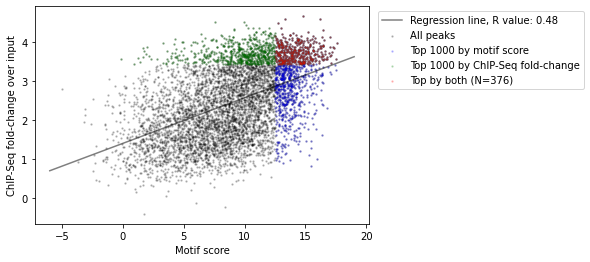

In [10]:
x = ctcf['score']
y = np.log(ctcf['FC_score'])

top_x = x>np.sort(x)[-1000]
top_y = y>np.sort(y)[-1000]
top_xy = top_x & top_y

f, ax = plt.subplots()

ax.scatter(x, y,
    s=2,
    alpha=0.2,
    color='black',
    label='All peaks'
)

ax.scatter(x[top_x], y[top_x],
    s=2,
    alpha=0.2,
    color='blue',
    label='Top 1000 by motif score'
)

ax.scatter(x[top_y], y[top_y],
    s=2,
    alpha=0.2,
    color='green',
    label='Top 1000 by ChIP-Seq fold-change'
)

ax.scatter(x[top_xy], y[top_xy],
    s=2,
    alpha=0.2,
    color='red',
    label=f'Top by both (N={np.sum(top_xy)})'
)


slope, intercept, r, p, se = linregress(x, y)

ax.plot([-6, 19], [intercept-6*slope, intercept+19*slope], 
        alpha=0.5,
        color='black',
        label=f"Regression line, R value: {r:.2f}")

ax.set(
    xlabel='Motif score',
    ylabel='ChIP-Seq fold-change over input')

ax.legend(bbox_to_anchor=(1.01,1), loc="upper left")

In [11]:
# Select the CTCF sites that are in top 1000 by both the ChIP-Seq data and motif score

top = (ctcf['score']>np.sort(ctcf['score'])[-1000]) & (ctcf['FC_score']>np.sort(ctcf['FC_score'])[-1000])

sites = ctcf[top]\
    .sort_values('FC_score', ascending=False)\
    .reset_index(drop=True)
sites.tail()

,chrom,start,end,name,score,strand,mid,FC_score
371,chr2,168119697,168119716,MA0139.1_CTCF_human,12.985375,-,168119706,31.129755
372,chr2,121085123,121085142,MA0139.1_CTCF_human,13.108506,+,121085132,31.081887
373,chr2,192162610,192162629,MA0139.1_CTCF_human,13.619296,-,192162619,31.018685
374,chr2,84023008,84023027,MA0139.1_CTCF_human,13.262424,+,84023017,31.014459
375,chr17,46044520,46044539,MA0139.1_CTCF_human,14.184245,+,46044529,31.014111


In [12]:
# Some CTCF sites might be located too close in the genome and interfere with analysis. 
# We will collapse the sites falling into the same 1000-bp genomic bin:
sites = bioframe.ops.cluster(sites, min_dist=1000)\
    .drop_duplicates('cluster')\
    .reset_index(drop=True)
sites.tail()

,chrom,start,end,name,score,strand,mid,FC_score,cluster,cluster_start,cluster_end
369,chr2,168119697,168119716,MA0139.1_CTCF_human,12.985375,-,168119706,31.129755,306,168119697,168119716
370,chr2,121085123,121085142,MA0139.1_CTCF_human,13.108506,+,121085132,31.081887,290,121085123,121085142
371,chr2,192162610,192162629,MA0139.1_CTCF_human,13.619296,-,192162619,31.018685,319,192162610,192162629
372,chr2,84023008,84023027,MA0139.1_CTCF_human,13.262424,+,84023017,31.014459,245,84023008,84023027
373,chr17,46044520,46044539,MA0139.1_CTCF_human,14.184245,+,46044529,31.014111,92,46044520,46044539


<a id='ondiag'></a>
## 3. On-diagonal pileup

On-diagonal pileup is the simplest, you need the positions of **features** (middlepoints of CTCF motifs) and the size of flanks aroung each motif. cooltools will create a snippet of Hi-C map for each feature. Then you can combine them into a single 2D pileup. 

[Go to top](#content)

In [13]:
# Convert dataframe with features to format digestible by cooltools.
# In future, we expect this step to evolve into user-friendly API.
flank = 100000
windows = snipping.make_bin_aligned_windows(
    resolution, 
    sites['chrom'], 
    sites['mid'],
    flank_bp=flank)
windows['strand'] = sites['strand']

# Assign genomic regions to windows:
supports = hg38_arms[['chrom', 'start', 'end']].values
windows = snipping.assign_regions(windows, supports)
windows.head()

,chrom,start,end,lo,hi,strand,region
0,chr17,41562000,41763000,41562,41763,-,chr17:24714921-83257441
1,chr17,39522000,39723000,39522,39723,+,chr17:24714921-83257441
2,chr17,45035000,45236000,45035,45236,+,chr17:24714921-83257441
3,chr2,219542000,219743000,219542,219743,-,chr2:93139351-242193529
4,chr17,17760000,17961000,17760,17961,-,chr17:0-24714921


<a id='iced'></a>
### 3.1. On-diagonal pileup of ICed Hi-C interactions

[Go to top](#content)

In [14]:
# Create the snipper object:
snipper = cooltools.snipping.CoolerSnipper(clr)

stack = cooltools.snipping.pileup(
        windows, 
        snipper.select, 
        snipper.snip) 

# Mirror reflect snippets when the feature is on the opposite strand
mask = np.array(windows.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]

# Aggregate. Note that some pixels might be converted to NaNs after IC, thus we aggreagte by nanmean: 
mtx = np.nanmean(stack, axis=2)

In [15]:
# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:
import cooltools.lib.plotting

Text(0, 0.5, 'relative position, kbp')

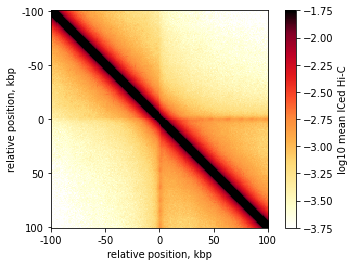

In [16]:
plt.imshow(
    np.log10(mtx),
    vmax = -3.75,
    vmin = -1.75,
    cmap='fall',
    interpolation='none')
plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

<a id='ooe'></a>
### 3. 2. On-diagonal pileup of observed over expected interactions

Sometimes you don't want to include the **distance decay** P(s) in your pileups. For example, when you make comparison of pileups between experiments and they have different P(s). Even if these differences are sight, they might affect the pileup of raw ICed Hi-C interactions. 

In this case, the observed over expected pileup is your choice. Prior to running the pileup function, you need to calculate expected interactions for chromosome arms. This step might be time-consuming, thus you may use the **parallelization** for this step. 

[Go to top](#content)

In [17]:
# Set up parallelization
import multiprocess
nthreads = 4

In [18]:
# Calculate expected interactions for chromosome arms
with multiprocess.Pool(nthreads) as pool:
    expected = cooltools.expected.diagsum(
        clr, 
        regions=hg38_arms, 
        transforms={
            'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
        },
    map=pool.map
    )
    
# Add annotation of chromosome arms to the dataframe, this will be changed in the future versions of cooltools
expected = pd.concat([expected, bioframe.region.parse_regions(expected.region)], axis=1).drop('name', axis=1)

# Calculate average number of interactions per diagonal, this will be changed in the future versions of cooltools
expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']

In [19]:
oe_snipper = cooltools.snipping.ObsExpSnipper(clr, expected)

# Create the stack of snips:
with multiprocess.Pool(nthreads) as pool:
    stack = cooltools.snipping.pileup(
            windows, 
            oe_snipper.select, 
            oe_snipper.snip,
            map=pool.map
            ) 

# Mirror reflect snippets when the feature is on the opposite strand
mask = np.array(windows.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]
    
mtx = np.nanmean(stack, axis=2)

<ipython-input-19-cfbb03f5b104>:16: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=2)


Text(0, 0.5, 'relative position, kbp')

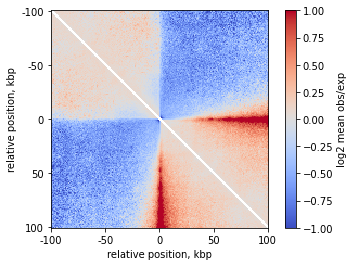

In [20]:
plt.imshow(
    np.log2(mtx),
    vmax = 1.0,
    vmin = -1.0,
    cmap='coolwarm',
    interpolation='none')
plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

<a id='snips'></a>
### 3.3. Inspect the snips

Aggregation is a convenient though dangerous step. It averages your data so that you cannot distinguish whether the signal is indeed average, or there is a single dataset that introduces a bias to your analysis. To make sure there are no outliers, you may want to use inspection of individual snippets.

Also, you might notice that we sort the dataframe with CTCF motifs by the strength of binding. We can utilize it and inspect the Micro-C maps at the positions of the strongest and weakest CTCF sites. Run the cell below and try to compare snippets with the lowest score to the snippets with the largest score. 

[Go to top](#content)

In [21]:
from ipywidgets import interact
from matplotlib.gridspec import GridSpec

n_examples = len(windows)

@interact(i=(0, n_examples-1))
def f(i):
    fig, ax = plt.subplots(figsize=[5,5])
    img = ax.matshow(
        np.log2(stack[:, :, i]),  
        vmin=-1,
        vmax=1,
        extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
        cmap='coolwarm'
    )
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(f'{i+1}-th snippet from top \n FC score: {sites.loc[i, "FC_score"]:.2f}\n and motif score: {sites.loc[i, "score"]:.2f}')
    plt.axvline(0, c='g', ls=':')
    plt.axhline(0, c='g', ls=':')

interactive(children=(IntSlider(value=186, description='i', max=373), Output()), _dom_classes=('widget-interac…

As another solution, you may create separate pileups for percentiles of your data by score:

<ipython-input-22-ccbc258779cd>:8: RuntimeWarning: Mean of empty slice
  Q_mtxs = [np.nanmean(stack[:, :, Q_selectors[i]], axis=2) for i in range(n_groups)]


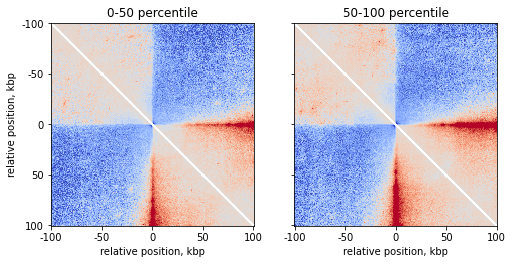

In [22]:
# TODO: add some strength of insulation for the pileup? 

n_groups = 2

groups = np.linspace(0, 100, n_groups+1)
Q_scores = np.percentile(sites.FC_score, groups)
Q_selectors = [(sites.FC_score>Q_scores[i])&(sites.FC_score<=Q_scores[i+1]) for i in range(n_groups)]
Q_mtxs = [np.nanmean(stack[:, :, Q_selectors[i]], axis=2) for i in range(n_groups)]


ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)

f, axs = plt.subplots(1, n_groups, sharex=True, sharey=True, figsize=(4*n_groups, 4))
for i in range(n_groups):
    ax = axs[i]
    ax.imshow(
        np.log2(Q_mtxs[i]),
        vmax = 1.0,
        vmin = -1.0,
        cmap='coolwarm',
        interpolation='none')
    
    ax.set(title=f'{groups[i]:.0f}-{groups[i+1]:.0f} percentile', 
           xticks=ticks_pixels, 
           xticklabels=ticks_kbp, 
           xlabel='relative position, kbp')

axs[0].set(yticks=ticks_pixels, 
       yticklabels=ticks_kbp, 
       ylabel='relative position, kbp')

f.show()

<a id='offdiag'></a>
## Off-diagonal pileup

**Off-diagonal pileups** are the averaged Hi-C maps around double anchors. In this case, the anchors are CTCF sites in the genome. 

[Go to top](#content)

In [23]:
from bioframe.genomeops import pair_by_distance

In [24]:
paired_sites = pair_by_distance(sites, min_sep=20000, max_sep=1000000, suffixes=('1', '2'))
paired_sites.loc[:, 'mid1'] = (paired_sites['start1'] + paired_sites['end1'])//2
paired_sites.loc[:, 'mid2'] = (paired_sites['start2'] + paired_sites['end2'])//2

In [25]:
print(len(paired_sites))
paired_sites.head()

915


,chrom1,start1,end1,name1,score1,strand1,mid1,FC_score1,cluster1,cluster_start1,...,start2,end2,name2,score2,strand2,mid2,FC_score2,cluster2,cluster_start2,cluster_end2
0,chr17,1056222,1056241,MA0139.1_CTCF_human,13.272118,-,1056231,35.072572,0,1056222,...,1649010,1649029,MA0139.1_CTCF_human,13.614584,+,1649019,48.132967,4,1649010,1649029
1,chr17,1056222,1056241,MA0139.1_CTCF_human,13.272118,-,1056231,35.072572,0,1056222,...,2026174,2026193,MA0139.1_CTCF_human,13.106067,-,2026183,48.490899,5,2026174,2026193
2,chr17,1187365,1187384,MA0139.1_CTCF_human,13.996208,-,1187374,69.994562,1,1187365,...,2026174,2026193,MA0139.1_CTCF_human,13.106067,-,2026183,48.490899,5,2026174,2026193
3,chr17,1259271,1259290,MA0139.1_CTCF_human,14.735101,+,1259280,31.643758,2,1259271,...,2026174,2026193,MA0139.1_CTCF_human,13.106067,-,2026183,48.490899,5,2026174,2026193
4,chr17,1276329,1276348,MA0139.1_CTCF_human,13.983562,+,1276338,35.440247,3,1276329,...,2026174,2026193,MA0139.1_CTCF_human,13.106067,-,2026183,48.490899,5,2026174,2026193


In [26]:
flank = 100000

windows1 = snipping.make_bin_aligned_windows(
    resolution, 
    paired_sites['chrom1'], 
    paired_sites['mid1'],
    flank_bp=flank)

windows2 = snipping.make_bin_aligned_windows(
    resolution, 
    paired_sites['chrom2'], 
    paired_sites['mid2'],
    flank_bp=flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, supports)

In [27]:
windows.head()

,chrom1,start1,end1,lo1,hi1,chrom2,start2,end2,lo2,hi2,region
0,chr17,956000,1157000,956,1157,chr17,1549000,1750000,1549,1750,chr17:0-24714921
1,chr17,956000,1157000,956,1157,chr17,1926000,2127000,1926,2127,chr17:0-24714921
2,chr17,1087000,1288000,1087,1288,chr17,1926000,2127000,1926,2127,chr17:0-24714921
3,chr17,1159000,1360000,1159,1360,chr17,1926000,2127000,1926,2127,chr17:0-24714921
4,chr17,1176000,1377000,1176,1377,chr17,1926000,2127000,1926,2127,chr17:0-24714921


We will use the expected calculated [above](#ooe):

In [28]:
oe_snipper = cooltools.snipping.ObsExpSnipper(clr, expected)

# create the stack of snips:
with multiprocess.Pool(nthreads) as pool:
    stack = cooltools.snipping.pileup(
            windows, 
            oe_snipper.select, 
            oe_snipper.snip,
            map=pool.map
            ) 
    
mtx = np.nanmean(stack, axis=2)

Text(0, 0.5, 'relative position, kbp')

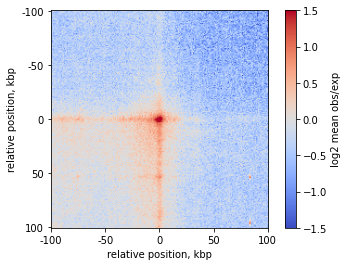

In [29]:
plt.imshow(
    np.log2(mtx),
    vmax = 1.5,
    vmin = -1.5,
    cmap='coolwarm')
plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')